# What is Chronos?

Chronos is a general purpose time series forecaster: whenever you have time related data, you can use it to predict the future.
Applications:
- Stock market prediction
- Audio generation
- Sales Forecast

Chronos makes use of large language models (LLMs). LLMs, though, only treat integer tokens (initially designed for words), so researchers used a process called **quantization** to transform temporal data (i.e. a graph chart) into a list of more simple tokens.

This is similar to what EnCodec does.

In [146]:
import pandas as pd  # requires: pip install pandas
import torch
from chronos import BaseChronosPipeline
import matplotlib.pyplot as plt  # requires: pip install matplotlib

pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",  # use "amazon/chronos-bolt-small" for the corresponding Chronos-Bolt model
    device_map="cuda",  # use "cpu" for CPU inference
    torch_dtype=torch.bfloat16,
)

df = pd.read_csv(
    "https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv"
)

print(df.describe())
print(df.head())

# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
# quantiles is an fp32 tensor with shape [batch_size, prediction_length, num_quantile_levels]
# mean is an fp32 tensor with shape [batch_size, prediction_length]
quantiles, mean = pipeline.predict_quantiles(
    context=torch.tensor(df["#Passengers"]),
    prediction_length=24,
    quantile_levels=[0.1, 0.5, 0.9],
)

       #Passengers
count   144.000000
mean    280.298611
std     119.966317
min     104.000000
25%     180.000000
50%     265.500000
75%     360.500000
max     622.000000
     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121


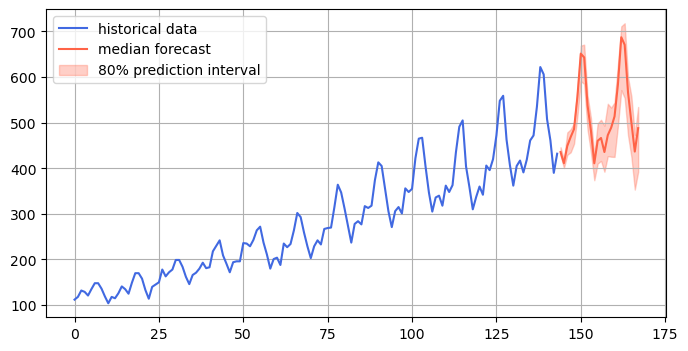

In [147]:
def plot_forecast(df, quantiles, data_column_name):
    forecast_index = range(len(df), len(df) + quantiles.shape[1])
    low, median, high = quantiles[0, :, 0], quantiles[0, :, 1], quantiles[0, :, 2]

    plt.figure(figsize=(8, 4))
    plt.plot(range(len(df)), df[data_column_name], color="royalblue", label="historical data")
    plt.plot(forecast_index, median, color="tomato", label="median forecast")
    plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
    plt.legend()
    plt.grid()
    plt.show()

plot_forecast(df, quantiles, data_column_name='#Passengers')

In [148]:
import datasets

def to_pandas(ds: datasets.Dataset) -> "pd.DataFrame":
    """Convert dataset to long data frame format."""
    sequence_columns = [col for col in ds.features if isinstance(ds.features[col], datasets.Sequence)]
    return ds.to_pandas().explode(sequence_columns).infer_objects()

df = datasets.load_dataset("autogluon/chronos_datasets", "monash_australian_electricity", split="train")
df = to_pandas(df)
df = df[200000:700000:1000]
print(len(df))

500


In [149]:
print(df.describe())
print()
print(df.head())


                        timestamp       target
count                         500   500.000000
mean   2008-11-14 10:00:57.600000  4552.039987
min           2002-01-06 08:00:00   882.130950
25%           2005-05-23 19:00:00  3784.910512
50%           2008-12-14 12:00:00  4591.798140
75%           2012-07-07 05:00:00  5153.814421
max           2015-03-17 12:00:00  9403.555978
std                           NaN  1085.904382

        id           timestamp       target
0  T000000 2013-05-29 16:00:00  7200.307346
0  T000000 2013-06-19 12:00:00  7518.884030
0  T000000 2013-07-10 08:00:00  8446.727596
0  T000000 2013-07-31 04:00:00  4865.428184
0  T000000 2013-08-21 00:00:00  6808.927834


In [150]:
col_name = 'target'

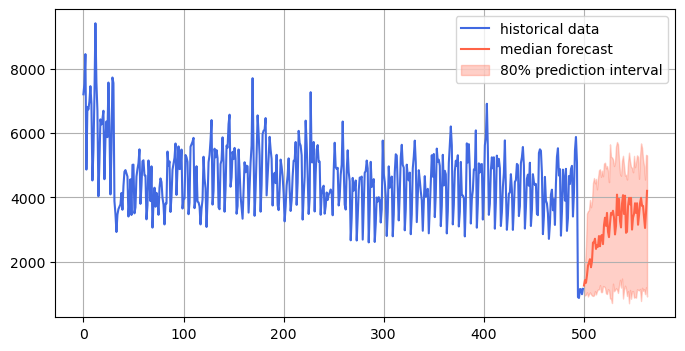

In [151]:
context = torch.tensor(df[col_name].to_numpy())

quantiles, mean = pipeline.predict_quantiles(
    context=context,
    prediction_length=64,
    quantile_levels=[0.1, 0.5, 0.9],
)

plot_forecast(df, quantiles, col_name)